In [1]:
# import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler

In [2]:
df_titanic = pd.read_csv('data/titanic.csv', index_col="PassengerId")

In [3]:
df_titanic.drop(columns=['Name', "Ticket", "Cabin"], inplace=True)
df_titanic.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
PassengerId,,,,,,,,
1,0,3,male,22.0,1,0,7.2500,S
2,1,1,female,38.0,1,0,71.2833,C
3,1,3,female,26.0,0,0,7.9250,S
4,1,1,female,35.0,1,0,53.1000,S
5,0,3,male,35.0,0,0,8.0500,S


#  Exploratory Data Analysis

## Target

In [4]:
df_titanic.Survived.value_counts()

0    549
1    342
Name: Survived, dtype: int64

## Numeric vs Target (Histogram)

C:\Users\Damianus Deni\Miniconda3\envs\jcopml\lib\site-packages\statsmodels\nonparametric\kde.py:444: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # will not work for two columns.
C:\Users\Damianus Deni\Miniconda3\envs\jcopml\lib\site-packages\statsmodels\nonparametric\kde.py:444: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X < clip[1])] # will not work for two columns.


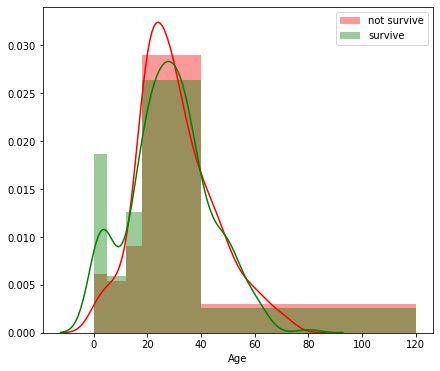

In [5]:
# membuat plot usia yang selamat dan tidak selamat
plt.figure(figsize=(7, 6))
sns.distplot(df_titanic.Age[df_titanic.Survived == 0], bins=[0, 5, 12, 18, 40, 120], color='r', label='not survive')
sns.distplot(df_titanic.Age[df_titanic.Survived == 1], bins=[0, 5, 12, 18, 40, 120], color='g', label='survive')
plt.legend()

In [6]:
# balita cenderung lebih selamat

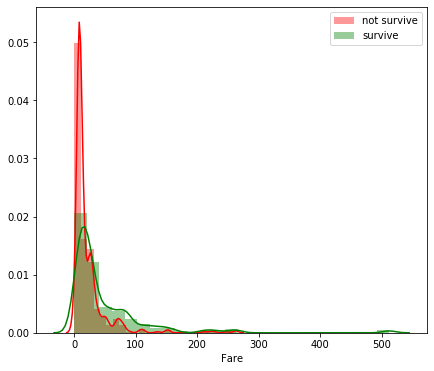

In [7]:
# membuat plot harga
plt.figure(figsize=(7, 6))
sns.distplot(df_titanic.Fare[df_titanic.Survived == 0], bins=25, color='r', label='not survive')
sns.distplot(df_titanic.Fare[df_titanic.Survived == 1], bins=25, color='g', label='survive')
plt.legend()

In [8]:
# yang bayar di bawah 25 dollar cenderung tidak selamat
# yang bayar mahal cenderung lebih selamat

## Categoric vs Target 

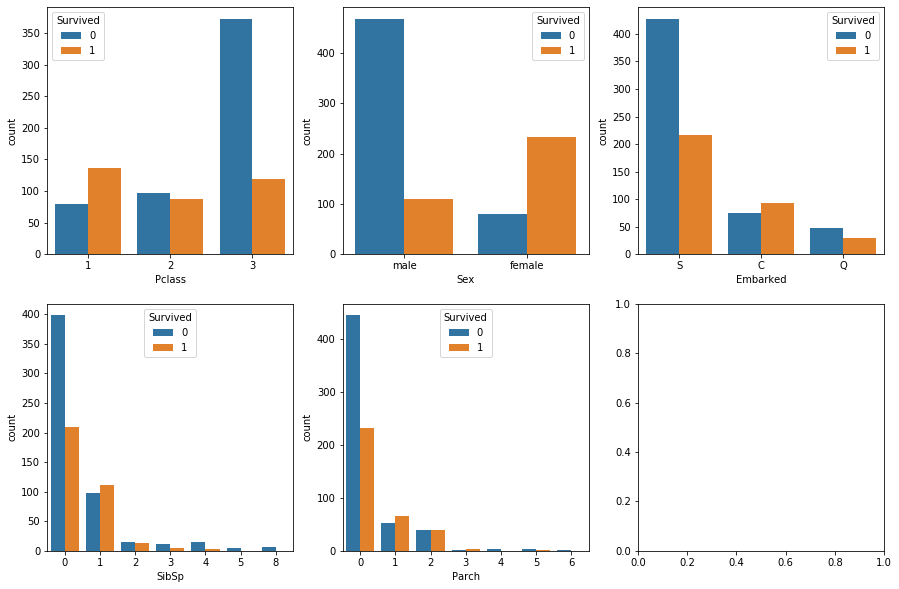

In [9]:
cat_var = ['Pclass', 'Sex', 'Embarked', 'SibSp', 'Parch']

fig, ax = plt.subplots(2, 3, figsize=(15, 10))

# plotting memakai looping
for cat, a in zip(cat_var, ax.flatten()):
    sns.countplot(cat, data=df_titanic, hue="Survived", ax=a)

In [10]:
# Pclass = kelas economy lebih cenderung tidak selamat
# Sex = male cenderung tidak selamat
# Embarked = orang Southampton kebanyakan tidak selamat
# SibSp = yang sendirian cenderung tidak selamat
# Parch = sama

# Feature Engineering


## Adding Feature --> isAlone 

In [11]:
df_titanic["isAlone"] = (df_titanic.SibSp == 0) & (df_titanic.Parch == 0)
df_titanic.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,isAlone
PassengerId,,,,,,,,,
1,0,3,male,22.0,1,0,7.2500,S,False
2,1,1,female,38.0,1,0,71.2833,C,False
3,1,3,female,26.0,0,0,7.9250,S,True
4,1,1,female,35.0,1,0,53.1000,S,False
5,0,3,male,35.0,0,0,8.0500,S,True


## binning

In [12]:
# binning usia
df_titanic.Age = pd.cut(df_titanic.Age, [0, 5, 12, 18, 40, 120], labels=["toddler", "children", "teenager", "adult", "elderly"])
df_titanic.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,isAlone
PassengerId,,,,,,,,,
1,0,3,male,adult,1,0,7.2500,S,False
2,1,1,female,adult,1,0,71.2833,C,False
3,1,3,female,adult,0,0,7.9250,S,True
4,1,1,female,adult,1,0,53.1000,S,False
5,0,3,male,adult,0,0,8.0500,S,True


In [13]:
# binning harga tiket
df_titanic.Fare = pd.cut(df_titanic.Fare, [0, 25, 100, 600], labels=["cheap", "expensive", "executive"])
df_titanic.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,isAlone
PassengerId,,,,,,,,,
1,0,3,male,adult,1,0,cheap,S,False
2,1,1,female,adult,1,0,expensive,C,False
3,1,3,female,adult,0,0,cheap,S,True
4,1,1,female,adult,1,0,expensive,S,False
5,0,3,male,adult,0,0,cheap,S,True


# Dataset Splitting

In [14]:
X = df_titanic.drop(columns="Survived")
y = df_titanic.Survived

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((712, 8), (179, 8), (712,), (179,))

# Preprocessor

In [15]:
from jcopml.pipeline import num_pipe, cat_pipe

In [16]:
# num_pipe(scaling="minmax") is equivalent with below
# numerical_pipeline = Pipeline([
#     ("imputer", SimpleImputer(strategy='median')), 
#     ("scaler", MinMaxScaler())
# ])


# cat_pipe(encoder="onehot") is equivalent with below
# categorical_pipeline = Pipeline([
#     ("imputer", SimpleImputer(strategy='most_frequent')),
#     ("encoder", OneHotEncoder())
# ])

In [23]:
df_titanic.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 9 columns):
Survived    891 non-null int64
Pclass      891 non-null int64
Sex         891 non-null object
Age         714 non-null category
SibSp       891 non-null int64
Parch       891 non-null int64
Fare        876 non-null category
Embarked    889 non-null object
isAlone     891 non-null bool
dtypes: bool(1), category(2), int64(4), object(2)
memory usage: 91.6+ KB


In [25]:
preprocessor = ColumnTransformer([
    ('numeric', num_pipe(scaling='minmax'), ["SibSp", "Parch"]),
    ('categoric', cat_pipe(encoder='onehot'), ["Pclass", "Sex", "Age", "Parch", "Fare", "Embarked", "isAlone"]),
])

# Training


In [26]:
from jcopml.tuning import grid_search_params as gsp

In [27]:
gsp.knn_params

{'algo__n_neighbors': array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29]),
 'algo__weights': ['uniform', 'distance'],
 'algo__p': [1, 1.5, 2]}

In [28]:
pipeline = Pipeline([
    ("prep", preprocessor),
    ("algo", KNeighborsClassifier())
])

model = GridSearchCV(pipeline, gsp.knn_params, cv=3, n_jobs=-1, verbose=1)
model.fit(X_train, y_train)

print(model.best_params_)
print(model.score(X_train, y_train), model.best_score_, model.score(X_test, y_test))

Fitting 3 folds for each of 90 candidates, totalling 270 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    2.3s


{'algo__n_neighbors': 27, 'algo__p': 2, 'algo__weights': 'uniform'}
0.8230337078651685 0.8062026498363059 0.7877094972067039


[Parallel(n_jobs=-1)]: Done 270 out of 270 | elapsed:    6.4s finished


# Kadang, effort tidak sebanding dengan hasil

Oleh sebab itu, selalu mulai dengan model yang sederhana (yang effort nya sedikit). Lalu perlahan coba yang effortnya lebih berat.